In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from parameters import *
from lib.utils import *
from lib.attacks import *

import numpy as np
import tensorflow as tf

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
x_train, y_train, x_test, y_test = load_dataset_mnist()

y_train_cat = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test_cat = keras.utils.to_categorical(y_test, NUM_LABELS)

In [5]:
def random_sample(size):

    # Generate samples from g
    z = np.random.normal(0, 1, size)
    # Sampled labels
    y_sampled = np.random.randint(0, 10, size[0])
    return z, y_sampled

def generate_random(g, size):

    z, y_sampled = random_sample(size)
    x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
    return x_g, y_sampled

def collage(images):
    img = (np.concatenate([np.concatenate([s for s in r], axis=1)
                           for r in np.split(images, 10)], axis=0) *
           127.5 + 127.5).astype(np.uint8)
    return np.squeeze(img)

def show(x):
    plt.imshow(x.reshape(28, 28) / 2 + 1, cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
def grad_acgan_cross_entropy(model):
    y_true = K.placeholder(shape=(OUTPUT_DIM, ))
    loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true, logits=model.output)
    grad = K.gradients(loss, model.input[0])
    return K.function([model.input[0], model.input[1], 
                       y_true, K.learning_phase()], grad)

def grad_acgan_hinge(model):
    
    labels = K.placeholder(shape=(OUTPUT_DIM, ), dtype=tf.int32)
    logits = model.output[0]
    i_label = tf.to_int32(tf.argmax(labels))
    y_label = logits[i_label]
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits))
    y_max = tf.where(tf.equal(i_label, i_max), 
                     y_2max[1], y_2max[0])
    loss = tf.maximum(0., 1. - y_label + y_max)
    grad = K.gradients(loss, model.input[0])
    return K.function([model.input[0], model.input[1], 
                       labels, K.learning_phase()], grad)

In [8]:
def PGD(model, x, y, grad_fn=None, norm="2", n_step=40, step_size=0.05,
        target=True, init_rnd=0.1):
    """
    PGD attack with random start
    """
    
    x_adv = np.zeros_like(x)
    y_cat = keras.utils.to_categorical(y, NUM_LABELS)
    
    for i, x_cur in enumerate(x):
        epsilon = np.random.uniform(size=x_cur.shape) - 0.5
        if norm == "2":
            try:
                epsilon /= np.linalg.norm(epsilon)
            except ZeroDivisionError:
                raise
        elif norm == "inf":
            epsilon = np.sign(epsilon)
        else:
            raise ValueError("Invalid norm!")
        
        x_adv[i] = x_cur + init_rnd * epsilon
        
    if not grad_fn:
        grad_fn = gradient_fn(model)
    start_time = time.time()

    for i, x_in in enumerate(x_adv):
        print(i)
        x_cur = np.copy(x_in)
        # Start update in steps
        for _ in range(n_step):
            grad = grad_fn([x_in.reshape(1, -1), y[i].reshape(1, -1), 
                            y_cat[i], 0])[0][0]
            if target:
                grad *= -1
            if norm == "2":
                try:
                    grad /= np.linalg.norm(grad)
                except ZeroDivisionError:
                    raise
            elif norm == "inf":
                grad = np.sign(grad)
            else:
                raise ValueError("Invalid norm!")

            x_cur += grad * step_size
            loss = model.evaluate([x_cur[np.newaxis], y[i, np.newaxis]], 
                                  y[i, np.newaxis], verbose=0)[0]
#             out = model.predict([x_cur[np.newaxis], y[i, np.newaxis]], 
#                                 verbose=0)[0]
#             if np.argmax(out) != y[i]:
#                 loss = np.maximum(0, 1 - out[y[i]] + np.sort(out)[-1])
#             else:
#                 loss = np.maximum(0, 1 - out[y[i]] + np.sort(out)[-2])
            print(loss)

        x_adv[i] = np.copy(x_cur)

        # Progress printing
        if (i % 200 == 0) and (i > 0):
            elasped_time = time.time() - start_time
            print("Finished {} samples in {:.2f}s.".format(i, elasped_time))
            start_time = time.time()

    return x_adv

--- 

In [9]:
model = build_cnn_mnist()
#model.load_weights('./tmp/weights/mnist_cnn_hinge.h5')
model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')
#model.load_weights('./tmp/mnist_cnn_margin_C1_L1/model.h5')
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [10]:
from lib.gan.model_acgan_mnist import *

latent_dim = 100
d = build_discriminator()
g = build_generator(latent_dim)
d.load_weights('./tmp/acgan_mnist/weight_d_epoch049.h5')
g.load_weights('./tmp/acgan_mnist/weight_g_epoch049.h5')

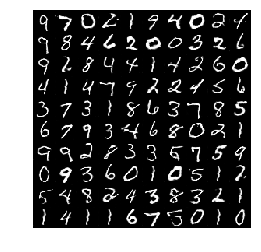

[9, 7, 0, 2, 1, 9, 4, 0, 2, 4]   [0.48, 0.59, 0.51, 0.53, 0.37, 0.49, 0.68, 0.53, 0.46, 0.5]
[9, 8, 4, 6, 2, 0, 0, 3, 2, 6]   [0.58, 0.55, 0.57, 0.46, 0.58, 0.52, 0.53, 0.52, 0.58, 0.48]
[9, 2, 8, 4, 4, 1, 4, 2, 6, 0]   [0.51, 0.49, 0.47, 0.54, 0.52, 0.37, 0.5, 0.47, 0.52, 0.55]
[4, 1, 4, 7, 9, 2, 2, 4, 5, 6]   [0.52, 0.37, 0.59, 0.64, 0.5, 0.48, 0.59, 0.49, 0.54, 0.58]
[3, 7, 3, 1, 8, 6, 3, 7, 8, 5]   [0.64, 0.54, 0.51, 0.37, 0.54, 0.51, 0.58, 0.61, 0.48, 0.49]
[6, 7, 9, 3, 4, 6, 8, 0, 2, 1]   [0.57, 0.5, 0.56, 0.58, 0.57, 0.5, 0.49, 0.54, 0.55, 0.37]
[9, 9, 2, 8, 3, 3, 5, 7, 5, 9]   [0.54, 0.56, 0.49, 0.51, 0.53, 0.6, 0.52, 0.59, 0.49, 0.52]
[0, 9, 3, 6, 0, 1, 0, 5, 1, 2]   [0.58, 0.43, 0.63, 0.52, 0.55, 0.37, 0.52, 0.5, 0.37, 0.51]
[5, 4, 8, 2, 4, 3, 8, 3, 2, 1]   [0.52, 0.64, 0.6, 0.45, 0.49, 0.6, 0.52, 0.58, 0.45, 0.37]
[1, 4, 1, 1, 6, 7, 5, 0, 1, 0]   [0.37, 0.57, 0.37, 0.37, 0.49, 0.56, 0.58, 0.48, 0.37, 0.55]


In [11]:
x_g, _ = generate_random(g, (100, latent_dim))
plt.imshow(collage(x_g), cmap='gray')
plt.axis('off')
#plt.savefig('acgan_latent.png', bbox_inches='tight')
plt.show()

y_pred = []
fake = []

for i, x in enumerate(x_g):
    tmp = d.predict(x.reshape(1, 28, 28, 1))
    fake.append(round(float(tmp[0]), 2))
    y_pred.append(np.argmax(tmp[1]))
    if (i + 1) % 10 == 0:
        print("{}   {}".format(y_pred, fake))
        y_pred = []
        fake = []

In [12]:
latent = Input(shape=(latent_dim, ))
image_class = Input(shape=(1, ), dtype='int32')
img = g([latent, image_class])
y = model(img)
combine = Model(inputs=[latent, image_class], outputs=y)
combine.trainable=False
combine.compile(loss=keras.losses.sparse_categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

In [13]:
z, y = random_sample((10, latent_dim))
y_cat = keras.utils.to_categorical(y, NUM_LABELS)

In [14]:
grad_fn = grad_acgan_cross_entropy(combine)
# grad_fn = grad_acgan_hinge(combine)
x_adv = PGD(combine, z, y, grad_fn=grad_fn, norm="2", n_step=200, 
            step_size=0.01, target=False, init_rnd=0.1)

0
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6912844777107239
0.6732854247093201
0.6547737717628479
0.6357442140579224
0.6179248094558716
0.6025053262710571
0.5897690057754517
0.5800334811210632
0.5719518065452576
0.5642039775848389
0.5558532476425171
0.547883152961731
0.5407178401947021
0.5349278450012207
0.5321367383003235
0.5319600105285645
0.5323220491409302
0.532839834690094
0.5340225100517273
0.5359853506088257
0.538356363773346
0.5412434935569763
0.5442756414413452
0.5478225350379944
0.5516630411148071
0.5549197793006897
0.5581014156341553
0.5604524612426758
0.5621727108955383
0.5639438033103943
0.565393328666687
0.5677847862243652
0.5710273385047913
0.5739890336990356
0.5752549171447754
0.5766400098800659
0.5785456895828247
0.580413997173

1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0645872354507446
1.0357967615127563
1.0071462392807007
0.9786144495

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6923290491104126
0.6634490489959717
0.6288591623306274
0.5985268354415894
0.5698966383934021
0.5417073965072632
0.5197151899337769
0.49671024084091187
0.47128427028656006
0.44853830337524414
0.4221622049808502
0.3924573063850403
0.36074039340019226
0.32744714617729187
0.2900943458080292
0.25743111968040466
0.22877360880374908
0.20352545380592346
0.18272514641284943
0.16200298070907593
0.14233270287513733
0.13405805826187134
0.13130386173725128
0.13800738751888275
0.14095216989517212
0.14493505656719208
0.1541583091020584
0.16767771542072296
0.1815321147441864
0.19239650666713715
0.1874658316373825
0.18041501939296722
0.18357311189174652
0.20091351866722107
0.2152065634727478
0.22071264684200287
0.225698322057724
0.24138624966144562
0.2591315507888794
0.2688485085964203
0.2695392966270447
0.25913873314857483
0.2538602650165558
0.24301309883594513
0.22859209775924683
0.20770885050296783
0.186

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593

0.6441266536712646
0.650773823261261
0.658177375793457
0.6666186451911926
0.6745253205299377
0.6814875602722168
0.6874354481697083
0.6898764371871948
0.692151665687561
0.6945487260818481
0.6986526846885681
0.7048959732055664
0.7110956311225891
0.7152953147888184
0.7188852429389954
0.7226957678794861
0.7270529270172119
0.7297062873840332
0.7300204634666443
0.7294449210166931
0.7284716367721558
0.7267802953720093
0.7209212183952332
0.7151376008987427
0.7092972993850708
0.7030402421951294
0.6959859132766724
0.6889826655387878
0.6825414896011353
0.6766881346702576
0.6717864274978638
0.6678441762924194
0.6639278531074524
0.6593310236930847
0.6549283266067505
0.650894284248352
0.6475909948348999
0.6440048217773438
0.6409643888473511
0.6358698606491089
0.6325317621231079
0.6285346150398254
0.6233876347541809
0.6182397603988647
0.613418698310852
0.6088747978210449
0.6047117114067078
0.6003025770187378
0.595946729183197
0.5916575193405151
0.5879158973693848
9
1.0986125469207764
1.09861254692077

In [15]:
x = g.predict([x_adv, y])

In [16]:
y

array([6, 4, 7, 0, 5, 3, 3, 3, 7, 9])

In [17]:
np.argmax(combine.predict([x_adv, y]), axis=1)

array([6, 1, 1, 0, 5, 3, 3, 3, 7, 9])

In [18]:
np.argmax(model.predict(x), axis=1)

array([6, 1, 1, 0, 5, 3, 3, 3, 7, 9])

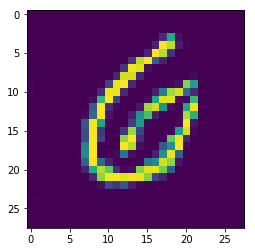

[[-2.5666106   0.25317454 -2.8553247  -1.4084927  -2.8862262   0.67604077
   0.91533566 -1.4923395  -1.2795153  -2.4145012 ]]


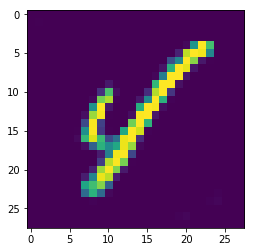

[[-8.319977   6.8941197 -7.400253  -8.844029   3.3208294 -1.5896407
  -5.0308557  2.2002945 -3.567749  -5.9235797]]


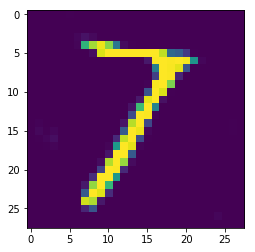

[[-10.259821    4.643989   -1.7286096  -4.348543   -2.5764632  -6.3882704
   -9.177335    3.4108176  -3.402111   -7.053626 ]]


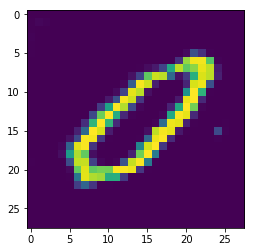

[[ 4.204975   -0.21695518 -0.7499858  -6.1449327   1.0900087  -4.3383307
  -2.5546863   1.1632849  -2.4808147  -3.0031078 ]]


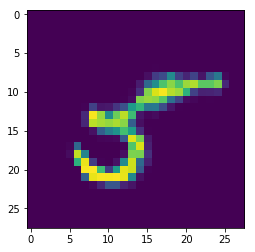

[[-11.329698     0.7591176  -11.360172    -0.12940003  -7.5260043
    8.747285    -5.5071883   -7.8320146   -8.211271    -9.375375  ]]


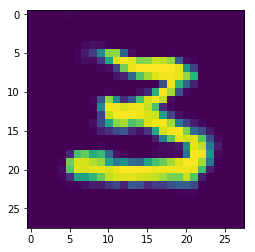

[[-15.140297   -3.542049  -12.400638   10.376531  -12.752647    7.262805
   -8.535779   -8.344532   -6.65645    -7.9433208]]


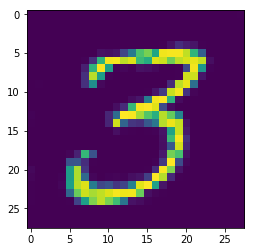

[[-13.794131  -9.610281 -13.836827  13.633538 -18.263474   8.009088
  -11.100341  -9.770034  -6.060309  -3.896098]]


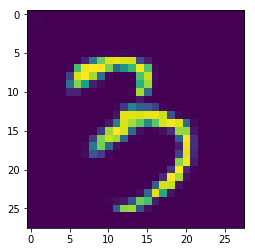

[[-9.489496   -2.8115792  -4.440976    6.377386   -7.0941596   3.5298176
  -6.2273197  -0.17672944 -4.5087795  -2.8172593 ]]


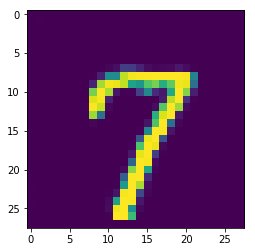

[[-9.765376    0.72842646 -9.452282   -6.643611    0.07180616 -3.9005015
  -7.73955     6.7886233  -6.2987657  -2.82877   ]]


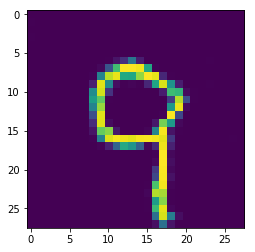

[[-5.5042114  -1.8164654  -3.8587208  -2.3795702   0.76621825 -0.36179227
  -6.7614865   1.4007232  -2.672469    2.416137  ]]


In [19]:
for x_cur in x:
    plt.imshow(x_cur.reshape(28, 28))
    plt.show()
    print(model.predict(x_cur.reshape(1, 28, 28, 1)))

In [170]:
np.max(x_adv[1])

2.4402044988261253

---
Simply iterate until a misclassification is found

In [101]:
adv_found = False
i = 0
while not adv_found:
    i += 1
    z, y = random_sample((100, latent_dim))
    y_pred = np.argmax(combine.predict([z, y]), axis=1)
    if np.sum(y_pred == y) != 100:
        z_adv, y_adv = z[y_pred != y], y[y_pred != y]
        break
print(i * 100)

500


In [102]:
np.sum(y_pred == y)

99

In [103]:
x = g.predict([z_adv, y_adv])

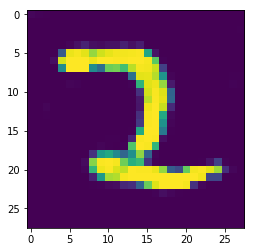

In [105]:
plt.imshow(x.reshape(28, 28))

In [106]:
np.argmax(model.predict(x), axis=1)

array([1])

In [ ]:
# try different loss function

---

In [18]:
from lib.OptCarlini_GAN import *

z, y = random_sample((10, latent_dim))
y_cat = keras.utils.to_categorical(y, NUM_LABELS)

opt = OptCarlini_GAN(combine, target=False, c=1, lr=0.01, init_scl=0.1,
                     loss_op=0, k=0, use_mask=False, decay=True)

x_adv = np.zeros_like(z)
norm = np.zeros(len(z))

for i, (zi, yi) in enumerate(zip(z, y_cat)):
    x_adv[i], norm[i] = opt.optimize(zi, yi, 
                                     './tmp/combine/acgan_cnn_smxe_mnist.h5', 
                                     n_step=1000, prog=True)

Step: 0, norm=0.771, loss=3.036, obj=3.808
Step: 50, norm=0.777, loss=0.000, obj=0.777
Step: 100, norm=0.696, loss=0.000, obj=0.696
Step: 150, norm=0.698, loss=0.003, obj=0.701
Step: 200, norm=0.695, loss=0.000, obj=0.695
Step: 250, norm=0.698, loss=0.000, obj=0.698
Step: 300, norm=0.691, loss=0.000, obj=0.691
Step: 350, norm=0.691, loss=0.001, obj=0.692
Step: 400, norm=0.690, loss=0.006, obj=0.695
Step: 450, norm=0.700, loss=0.000, obj=0.700
Step: 500, norm=0.692, loss=0.004, obj=0.695
Step: 550, norm=0.693, loss=0.000, obj=0.693
Step: 600, norm=0.695, loss=0.000, obj=0.695
Step: 650, norm=0.697, loss=0.000, obj=0.697
Step: 700, norm=0.698, loss=0.000, obj=0.698
Step: 750, norm=0.697, loss=0.000, obj=0.697
Step: 800, norm=0.694, loss=0.000, obj=0.694
Step: 850, norm=0.697, loss=0.001, obj=0.698
Step: 900, norm=0.698, loss=0.000, obj=0.698
Step: 950, norm=0.691, loss=0.000, obj=0.691
Step: 0, norm=0.760, loss=6.978, obj=7.739
Step: 50, norm=0.012, loss=6.982, obj=6.994
Step: 100, norm=

Step: 150, norm=0.707, loss=0.000, obj=0.707
Step: 200, norm=0.700, loss=0.003, obj=0.702
Step: 250, norm=0.703, loss=0.000, obj=0.703
Step: 300, norm=0.703, loss=0.000, obj=0.703
Step: 350, norm=0.701, loss=0.001, obj=0.702
Step: 400, norm=0.702, loss=0.000, obj=0.702
Step: 450, norm=0.700, loss=0.002, obj=0.703
Step: 500, norm=0.704, loss=0.000, obj=0.704
Step: 550, norm=0.703, loss=0.000, obj=0.703
Step: 600, norm=0.703, loss=0.000, obj=0.703
Step: 650, norm=0.700, loss=0.003, obj=0.703
Step: 700, norm=0.704, loss=0.000, obj=0.704
Step: 750, norm=0.707, loss=0.000, obj=0.707
Step: 800, norm=0.705, loss=0.000, obj=0.705
Step: 850, norm=0.701, loss=0.001, obj=0.702
Step: 900, norm=0.700, loss=0.002, obj=0.702
Step: 950, norm=0.703, loss=0.000, obj=0.703


In [19]:
y

array([8, 1, 8, 3, 9, 9, 0, 7, 7, 9])

In [20]:
np.argmax(combine.predict([x_adv, y]), axis=1)

array([2, 1, 3, 5, 4, 7, 0, 7, 7, 4])

In [21]:
x = g.predict([x_adv, y])
np.argmax(model.predict(x), axis=1)

array([2, 1, 3, 5, 4, 7, 0, 7, 7, 4])

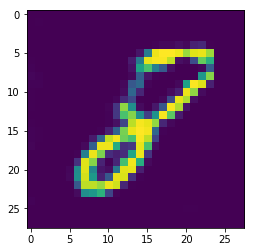

[[-5.200683   -2.7805693   2.1222546  -1.135436   -5.6081457  -0.24681793
  -3.4783373  -2.695622    2.1217148  -6.759361  ]]


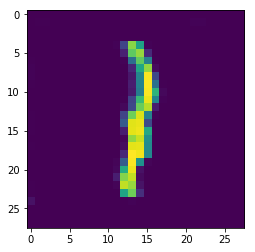

[[-6.5696588   5.9941173  -4.245597   -3.2448006  -1.8200564  -0.98799384
  -3.0639088  -1.4769727  -5.290218   -5.1526637 ]]


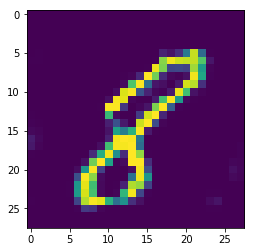

[[-6.649335   -0.42148986 -3.4615066   1.4919664  -4.2847867  -1.3871037
  -3.861333   -1.944639    1.4907899  -5.478606  ]]


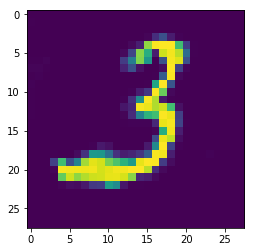

[[ -9.144882    -0.87740874  -6.880241     5.209285    -5.4859166
    5.2094264   -1.3704187   -5.660592   -10.390749    -7.9485445 ]]


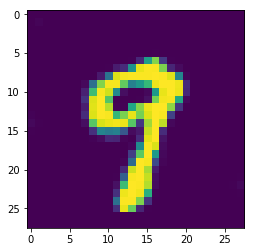

[[-9.663964  -1.5734876 -9.339236  -4.43768    4.398026  -1.7963163
  -9.278225   1.4193201 -4.293131   4.3980145]]


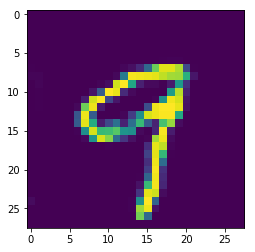

[[-10.316738    -4.1659656  -10.305016    -4.273915     1.2868692
   -0.05100935  -8.670932     3.7997973   -4.620361     3.7995355 ]]


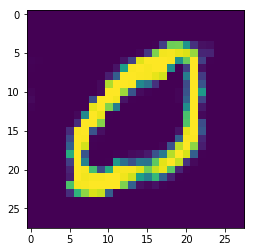

[[ 4.2760925 -1.4353864 -1.8938273 -6.663487  -2.743238  -4.073891
  -2.4527693  1.0302571 -3.7974422 -1.8212118]]


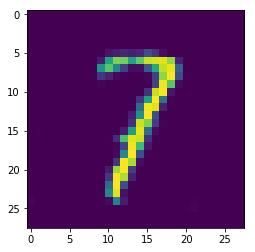

[[-6.047575   1.6245148 -3.1490269 -1.5431118 -0.5948941 -2.6065648
  -4.160546   1.9098269 -1.890882  -2.7378955]]


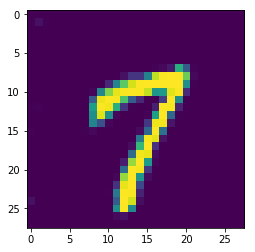

[[-8.408651   1.9771512 -7.973067  -4.245144   1.2672417 -2.694823
  -5.277905   4.6289835 -5.9819493 -2.5206492]]


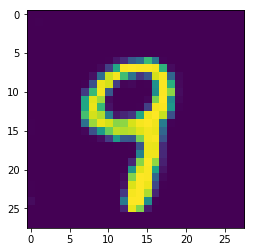

[[-8.149441  -1.0920604 -7.561497  -3.287735   4.321897  -3.0302
  -8.527914   1.5449913 -2.5081258  4.3215365]]


In [22]:
for x_cur in x:
    plt.imshow(x_cur.reshape(28, 28))
    plt.show()
    print(model.predict(x_cur.reshape(1, 28, 28, 1)))

In [13]:
combine.save_weights('temp.h5')

In [14]:
latent = Input(shape=(latent_dim, ))
image_class = Input(shape=(1, ), dtype='int32')
img = g([latent, image_class])
y = model(img)
combine = Model(inputs=[latent, image_class], outputs=y)

In [15]:
combine.load_weights('temp.h5')

In [16]:
combine.input[0].shape[1].value

100

In [17]:
combine.get_input_at(0)

[<tf.Tensor 'input_6:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'input_7:0' shape=(?, 1) dtype=int32>]

---

In [20]:
x_train, y_train, x_test, y_test = load_dataset_fmnist()

In [27]:
len(x_test)

10000